This script calculates an airfoil and outputs it to a format to be read by gmsh works for gmsh 4.7.1

In [1]:
#import common modules
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

# import fish utility modules
import airfoil as ar

from scipy import optimize

First we specify the thickness and chord length and then call the naca4 function in `airfoil.py`.  The format for that function is naca4(x_coordinates, thickness, camber, location of max thickness, closed trailing edge, chord length)  

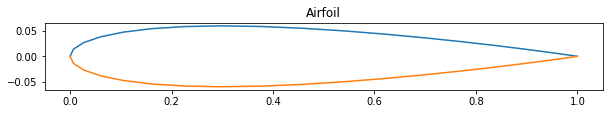

In [2]:
# half-cosine spacing
coord_points = 20   # number of points for upper and lower surface
beta = np.linspace(0, np.pi, coord_points)
dx = (0.5*(1-np.cos(beta)))
# uniform spacing
#dx = np.linspace(0.0, chord, 200)

chord = 1.0   # chord
t = 0.12   # thickness
m = 0.0    # camber
p = 0.3    # location of maximum camber
TE = True  # trailing edge closed

# call the functoin
x, y = ar.naca4(dx, t, m, p, TE, chord)

#convert coordinates to upper and lower arrays
xu = x[0]
xl = x[1]
yu = y[0]
yl = y[1]

# plot the results
f1, ax1 = plt.subplots(figsize=(10,20))
ax1.plot(xu, yu)
ax1.plot(xl, yl)
ax1.set_title('Airfoil')
ax1.set_aspect('equal')

Write to a .geo file

In [3]:
# Create array for writing
point = np.zeros((2*coord_points-2,3));
ind = 0;

point[0:coord_points, 0] = xu
point[0:coord_points, 1] = yu
point[0:coord_points, 2] = 0.0

point[coord_points:, 0] = np.flipud(xl[1:-1])
point[coord_points:, 1] = np.flipud(yl[1:-1])
point[coord_points:, 2] = 0.0

num_points = point.shape[0];
airfoil_point_numbers = np.arange(1, num_points, 1)
num_lines = num_points;

We can make things easier by defining a characteristic length for the mesh and a fluid domain based on the geometry

In this case:

all variables are a factor of total length e.g. 40 is 40 * length of airfoil

Lx_plus = length behind the airfoil

Lx_minus = length in front of airfoil

Ly = length top and bottom of airfoil

In [4]:
airfoil_cl = 0.05
wall_cl = 0.25
Lx_plus = 1.5
Lx_minus = -0.5
Ly_plus = 0.5
Ly_minus = -0.5 

No we should calculate the y+ value and all our boundary layer values

Credit to https://www.fluidmechanics101.com/pdf/calculators.pdf

For the calculation processes

In [44]:
# Define our setup variables
U = 1.0                                 # Freestream Velocity
L = 1.0                                 # Length            
density = 1025                          # fluid density
kinVisc = 2.5e-11                       # kinematic viscosity of fluid
dynamicVisc = density * kinVisc         # dynamic viscosity of fluid
yPlus = 5.0                             # desired Y+
growth_ratio = 1.1                      # growth ratio
N = 20                                  # number of inflation layers

# calculate the Reynolds Number
Re = U * L / kinVisc

# calculate the skin friction coefficient
Cf = (2*np.log10(Re) - 0.65)**(-2.3)

# calculate the shear wall stress
tw = 0.5 * density * U**2 * Cf

# calculate the friction velocity
ut = np.sqrt(tw / density)

# calculate yp where yp is the distance to the centroid of the first cell
# based on desired y+. yH is the first cell height which is 2 times the centroid
yp =  (yPlus * dynamicVisc) / (ut * density)

yH = 2 * yp

# Estimate the boundary layer thickness using the Blasius solution
# laminar and turbulent are given here
if ( Re < 4e5):
    delta = 4.91 * L / np.sqrt(Re)
else:
    delta = 0.38 * L / Re**(1/5)

# calculate the total thickness of the inflation layers yT
# specify the growth ratio
yT = yH * ((1 - growth_ratio**N)/(1 - growth_ratio))

#f = lambda r: (1.14e-8 * ((1 - r**20)/(1 - r)) - 0.00288)

#growth_ratio_calc = optimize.fsolve(f, 1.1)
# Give the final layer thickness
yFinal = yH * growth_ratio**(N - 1)

In [ ]:
#Write data to the .geo file
with open('airfoil_bl.geo', 'w') as df:
    # first we write the variables for easy changing locally later
    df.write('airfoil_cl = %f;\n' % (airfoil_cl))
    df.write('wall_cl = %f;\n' % (wall_cl))
    df.write('Lx_plus = %f;\n' % (Lx_plus * chord))
    df.write('Lx_minus = %f;\n' % (Lx_minus * chord))
    df.write('Ly_plus = %f;\n' % (Ly_plus * chord))
    df.write('Ly_minus = %f;\n' % (Ly_minus * chord))
    df.write('\n')

    for i in np.arange(0, num_points, 1):
        df.write('Point(%i) = {%f, %f, %f, airfoil_cl};\n' % (i+1, point[i,0], point[i,1],
                                                    point[i,2]))
    df.write('\n')
    
    # define the domain point numbers and domain line numbers
    domain_points = np.arange(num_points + 1, num_points + 5, 1)
    domain_lines = np.arange(num_lines + 1, num_lines + 5, 1)
    line_loops = np.array([101, 102])
    plane_surface = np.array([201])
    
    # write the fluid domain points
    df.write('// Define bounding box corners for fluid domain \n')        
    df.write('Point(%i) = {Lx_minus, Ly_minus, 0.0000, wall_cl};\n' % (domain_points[0]))
    df.write('Point(%i) = {Lx_minus, Ly_plus, 0.0000, wall_cl};\n' % (domain_points[1]))
    df.write('Point(%i) = {Lx_plus, Ly_plus, 0.0000, wall_cl};\n' % (domain_points[2]))
    df.write('Point(%i) = {Lx_plus, Ly_minus, 0.0000, wall_cl};\n' % (domain_points[3]))
    df.write('\n')
    
    # write the fluid domain lines
    df.write('// Make line loops for the fluid domain\n')
    df.write('Line(%i) = {%i, %i};\n' % (domain_lines[0], domain_points[0], domain_points[1]))
    df.write('Line(%i) = {%i, %i};\n' % (domain_lines[1], domain_points[1], domain_points[2]))
    df.write('Line(%i) = {%i, %i};\n' % (domain_lines[2], domain_points[2], domain_points[3]))
    df.write('Line(%i) = {%i, %i};\n' % (domain_lines[3], domain_points[3], domain_points[0]))
    df.write('\n')
    
    # combine the loops into a surface
    df.write('// Combine the fluid domain lines\n')
    df.write('Line Loop(' + str(line_loops[0]) + ') = {' + np.array2string(domain_lines, separator = ', ').strip('[]') + '};\n')
    
    df.write('\n')
    df.write('// combine foil points into a bspline \n')
    df.write('BSpline(1) = {'  + str(airfoil_point_numbers[0]) + ':' + str(coord_points) + '};\n')
    df.write('BSpline(2) = {' + str(coord_points) + ':' + str(num_points) + ',' +  str(airfoil_point_numbers[0]) + '};\n')
    df.write('Line Loop(' + str(line_loops[1]) + ') = {1, 2};\n') 
    df.write('\n')

    df.write('Plane Surface(' + str(plane_surface[0]) + ') = {101, 102};\n')
    
    df.write('\n')
    # extrude the surface so we can name the boundaries
    df.write('Extrude {0, 0, 1} {\n Surface{' + str(plane_surface[0]) + '};\n Layers{1};\n Recombine;\n}')
    df.write('\n')

    # define the physical surface patches
    df.write('// Define the physical surfaces -> values are obtained via the GUI \n')
    df.write('Physical Surface("overset") = {212, 216, 220, 224}; \n')
    df.write('Physical Surface("symFront") = {233}; \n')
    df.write('Physical Surface("symBack") = {201}; \n')
    df.write('Physical Surface("wingTop") = {232}; \n')
    df.write('Physical Surface("wingBottom") = {228}; \n')
    df.write('\n')

    # define the internal volume
    df.write('// Define the internal volume - usually 1 but obtained from GUI\n')
    df.write('Physical Volume("internal") = {1};\n')
    df.write('\n')

    # define the boundary layer addition
    df.write('Define the boundary layer \n')
    df.write('Field[1] = BoundaryLayer;\n')
    df.write('Field[1].EdgesList = {')

In [ ]:
//Define Boundary Layer
Field[1] = BoundaryLayer;
Field[1].EdgesList = {5, 227, 208, -226, 206, 6};
Field[1].NodesList = {1,1021, 1022, 160};
Field[1].FacesList = {232, 228};
Field[1].FanNodesList = {1,1021, 1022, 160};
Field[1].FansList = {5, 6};
Field[1].hfar = 0.01;
Field[1].hwall_n = 0.0005;
Field[1].thickness = 0.02;
Field[1].ratio = 1.11;
Field[1].AnisoMax = 10;
Field[1].Quads = 1;
Field[1].IntersectMetrics = 0;
BoundaryLayer Field = 1;